# Results
In this notebook we visualize the results of one simulation. For our analysis of the results, read our paper.  
To configure which simulation to visualize, set the `results_dir` variable to the path of the simulation results.

**Disclaimer:**
To visualize our results, we don't use Julia, but Python, because there is no need for performance optimized code and Python offers a simpler and more convenient way to work with data.

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("Accent")

In [2]:
results_dir = "../results/a10_r5-a5_d2_w2"

In [3]:
results = pd.read_csv(os.path.join(results_dir, "all_results.csv"))

Before diving into any visualizations, we prepare the results DataFrame.
E.g. we add the column `perc_load_shedding`, which contains the average expedcted load shedding in percent.

In [4]:
results["architecture"] = results["source_path"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[1])
results = results.drop(columns=["source_path"])

results["perc_load_shedding"] = results["objective_value"] / results["mean_load"] * 100
results.head()

,month,termination_status,objective_value,solve_time,mean_load,reinforced_busses,architecture,perc_load_shedding
0,1,OPTIMAL,3901.501502,788.921098,19844.714687,"B90,B38,B30,B8,B42",2013,19.660154
1,2,OPTIMAL,3738.276954,155.684526,21189.417399,"B12,B105,B17,B26,B8",2013,17.642188
2,3,OPTIMAL,2884.246047,198.181797,19799.179600,"B90,B38,B26,B8,B65",2013,14.567503
3,4,OPTIMAL,3590.924941,552.391652,18338.755607,"B38,B26,B8,B4,B104",2013,19.581072
4,5,OPTIMAL,3308.517106,291.595991,17161.718872,"B5,B38,B26,B8,B4",2013,19.278472


## Visualizations
First we plot both the expected load shedding and the expected load shedding in
percent for each architecture as boxplots.

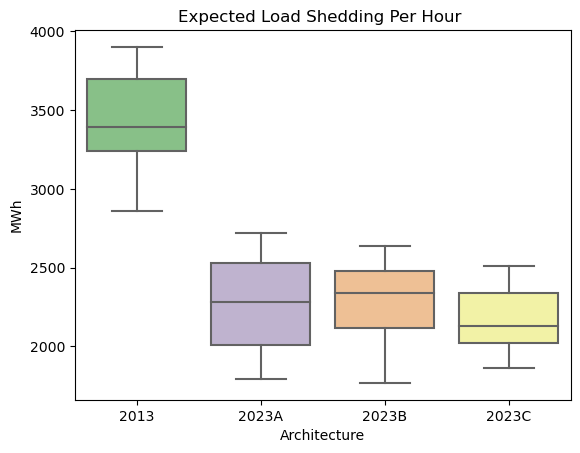

In [5]:
fig, ax = plt.subplots()

sns.boxplot(results, x="architecture", y="objective_value", ax=ax)
ax.set_title("Expected Load Shedding Per Hour ")
ax.set_ylabel("MWh")
ax.set_xlabel("Architecture")
plt.savefig(os.path.join(results_dir, "demand_shedding_per_architecture.png"), dpi=300)

plt.show()

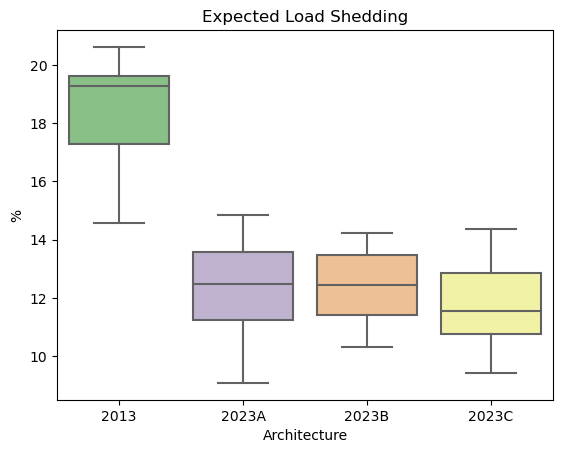

In [6]:
fig, ax = plt.subplots()

sns.boxplot(results, x="architecture", y="perc_load_shedding", ax=ax)
ax.set_title("Expected Load Shedding")
ax.set_ylabel("%")
ax.set_xlabel("Architecture")
plt.savefig(os.path.join(results_dir, "demand_shedding_per_architecture_perc.png"), dpi=300)

plt.show()

In [7]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

Now we plot the expected load shedding and the expected load shedding in
percent per month in a dotted line graph.

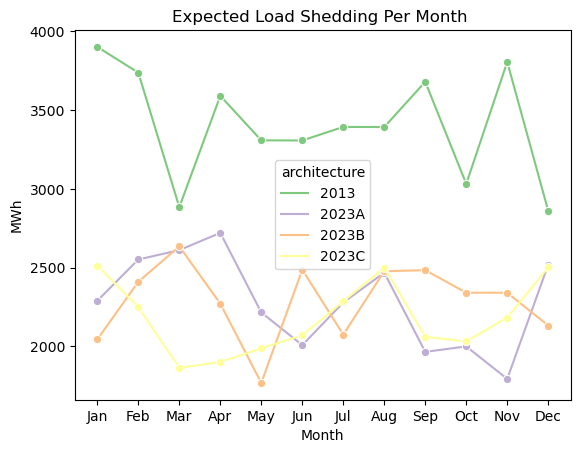

In [8]:
fig, ax = plt.subplots()

results_tmp = results.copy()
results_tmp["month"] = results_tmp["month"].apply(lambda x: months[x - 1])

sns.lineplot(
    results_tmp, x="month", y="objective_value", hue="architecture", marker="o", ax=ax
)
ax.set_title("Expected Load Shedding Per Month ")
ax.set_ylabel("MWh")
ax.set_xlabel("Month")

plt.savefig(os.path.join(results_dir, "demand_shedding_per_month.png"), dpi=300)

plt.show()


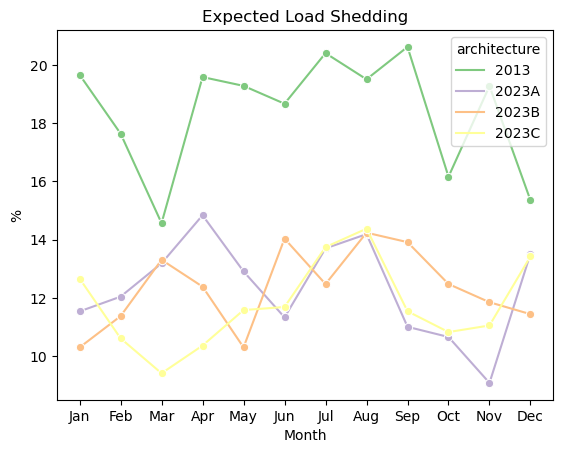

In [9]:
fig, ax = plt.subplots()


sns.lineplot(
    results_tmp, x="month", y="perc_load_shedding", hue="architecture", marker="o", ax=ax
)
ax.set_title("Expected Load Shedding")
ax.set_ylabel("%")
ax.set_xlabel("Month")

plt.savefig(os.path.join(results_dir, "percentage_demand_shedding_per_month.png"), dpi=300)

plt.show()


Last we also want to investigate the reinforced busses.
To do that we want to know how often a bus got reinforced and how many busses
got reinforced frequently (over 50% of the time).

In [10]:
bus_count_per_arch = {architecture: {} for architecture in results["architecture"].unique()}

for architecture, df in results.groupby("architecture"):
	for reinforced_busses in df["reinforced_busses"]:
		for bus in reinforced_busses.split(","):
			bus_count_per_arch[architecture][bus] = bus_count_per_arch[architecture].get(bus, 0) + 1

bus_count_df = pd.DataFrame(bus_count_per_arch)
bus_count_df = bus_count_df.fillna(0).astype(int)
bus_count_df = bus_count_df.sort_values(by="2023C", ascending=False)
bus_count_df.head(5)

,2013,2023A,2023B,2023C
B8,12,12,12,11
B38,8,7,8,10
B26,9,8,11,6
B4,5,6,4,6
B81,2,3,1,5


We also want to display the percentage how often a bus got reinforced.

In [11]:
bus_count_df_perc = (bus_count_df / 12 * 100)
bus_count_df_perc.round(2).head(5)

,2013,2023A,2023B,2023C
B8,100.00,100.00,100.00,91.67
B38,66.67,58.33,66.67,83.33
B26,75.00,66.67,91.67,50.00
B4,41.67,50.00,33.33,50.00
B81,16.67,25.00,8.33,41.67


Now, let's count the number of busses that got reinforced frequently (over 50% of the time).

In [12]:
n_busses_reinforced_often = ((bus_count_df_perc >= 50).sum())
for architecture, n_busses in n_busses_reinforced_often.items():
	print(f"{architecture}: {n_busses} busses reinforced at least 50% of the time")

2013: 3 busses reinforced at least 50% of the time
2023A: 4 busses reinforced at least 50% of the time
2023B: 3 busses reinforced at least 50% of the time
2023C: 4 busses reinforced at least 50% of the time
